## **Transcription speech to text (+ traduction)**

<br>

> #### &emsp; &emsp; Ce notebook contient :
>
> &emsp; Un bref rappel du contexte (utilité de l'application déployée)
>
> 1. La présentation et l'exploration du testing set
>
> 2. Notre baseline : <br> le modèle wav2vec2 pour la trancription <br>
>    (+ nllb-200-distilled-600M pour la traduction)
>
> 3. La nouvelle méthode : modèle whisper <br>
>
> 4. La comparaison des résultats des modèles speech to text, <br>
>    en évaluant (WER) la qualité des transcripts réalisés par les 2 modèles <br>
>
> 5. Une évaluation plus subjective de la qualité des traductions obtenues <br>
>
> &emsp; En conclusion, une synthèse récapitulative, baseline vs nouvelle méthode <br><br>


## 0 Contexte, Imports


In [116]:
# Les cas d'utilisation possibles d'un traducteur automatique sont très variés.
# Cet outil (de pure science-fiction il y a encore quelques années !)
# peut aider bien sûr lors d'un voyage par exemple, ou dans le cadre professionnel.
# Il permet à deux personnes ne parlant pas la même langue de communiquer très facilement.

# L'application déployée dans ce projet a été développée pour une situation bien précise :
# Il s'agit de répondre aux besoin d'un restaurant situé dans une zone touristique...
# et se préparant de plus à l'approche des jeux olympiques.
# Précisons aussi que leur conexion internet a été mauvaise par le passé (désormais ils ont la fibre).
# Cela nous donne des objectifs précis.

# Voici les points soulignés par la cliente, gérante du restaurant :

# détection auto
# Imaginons qu'un client se présente, mais personne ne le comprend.
# Pire, personne ne parvient à identifier avec certitude la langue qu'il parle.
# C'est la première chose que notre modèle doit être capable de faire,
# détecter automatiquement la langue.

# bruit
# L'environnement d'un restaurant n'est pas du tout idéal, car il y a généralement un fonds sonore.
# Le modèle devra donc autant que possible être robuste à un certain niveau de bruit.

# fiabilité, rapidité
# Le service d'un restaurant comporte souvent des "rushs" où il est essentiel pour l'équipe
# d'être très efficace, pour apporter les repas aussi vite que possible.
# Le modèle déployé doit donc être suffisant fiable (la traduction doit permettre de comprendre
# le client), mais aussi rapide ; ici cela a réelle importance.

# confidentialité / sécurité
# La gérante souhaite être certaine que la confidentialité des clients est assurée.
# Pour cette raison, plutôt que d'utiliser une API, nous allons importer les modèles.
# L'appli est déployée sur le cloud avec streamlit, mais le restaurant utilise une version
# totalement locale, où rien n'est uploadé.
# On peut vérifier dans le code (app_rosetta.py) que l'enregistrement audio n'est jamais
# sauvegardé, il s'agit d'un fichier temporaire.
# Cela nous amène au dernier point :

# hors-connexion
# Le restaurant souhaite que l'outil fonctionne hors connexion, en cas de coupure du réseau
# ou éventuelle coupure électrique.
# Ils utiliseront donc la version locale, qui a servi au déployement,
# et qui fonctionne sans problème, connexion ou pas.

# facilité d'utilisation, design simple


### 0.1 Librairies, réglages


In [117]:
# paths, folders/files
import os, sys, random
from glob import glob
import re
import time

# math, dataframes
import numpy as np
import pandas as pd

# Visualisation
from pprint import pprint
import matplotlib as matplot
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

# audio
%pip install soundfile sounddevice
import soundfile as sf
import sounddevice as sd

try:
    import librosa
except:
    print('Installing librosa...')
    %pip install librosa
    print('done')
    import librosa

import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav

try:
    from pydub import AudioSegment
    from pydub.playback import play
except:
    print('Installing pydub...')
    %pip install --upgrade pydub
    print('done')
    from pydub import AudioSegment
    from pydub.playback import play

# NN models
try:
    import torch
except:
    print('Installing pytorch...')
    %pip install --upgrade torch
    print('done')
    import torch

import transformers
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

try:
    from tqdm.auto import tqdm
except:
    %pip install tqdm
    from tqdm.auto import tqdm

%env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda')

try:
    import whisper
except:
    print('Installing whisper...')
    %pip install git+https://github.com/openai/whisper.git
    print('done')
    import whisper

# save model & results
import pickle


print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('librosa version ' + librosa.__version__)
print('plt version ' + matplot.__version__) # 3.7 pour compatibilité avec librosa.display.waveshow
print('transformers ' + transformers.__version__) # > 4.3 ? ok

# plt.style.use('ggplot')
pd.set_option('display.max_rows', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
# pandarallel.initialize(progress_bar=False, nb_workers=7)


Note: you may need to restart the kernel to use updated packages.
env: TOKENIZERS_PARALLELISM=true

Python version 3.11.8 (main, Feb 26 2024, 21:39:34) [GCC 11.2.0]
pandas version 2.2.1
librosa version 0.10.1
plt version 3.7.2
transformers 4.37.2

Number of CPU cores: 8


### 0.2 Fonctions utiles


In [118]:
# dataframes


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, duplicates,
    and missing values.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True (default), it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


In [119]:
# graphs EDA


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, color='#7cf', ax=ax, rwidth=0.9)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, color='#7cf', showfliers=False, medianprops=medianprops,
                      patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def generate_random_pastel_colors(n):
    """
    Makes pretty colors... Sometimes :)
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def doughnut(df, feature, title, width=6, height=6, nb_colors=2):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(nb_colors)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


[(0.667, 0.91, 0.733, 1.0), (0.816, 0.91, 0.847, 1.0)]


### 0.3 Variables globales


In [120]:
size_test = 2426 # max 2426, usually 1 or 300
model_type = 'tiny' # tiny, base, small, medium, large

max_exemples = 20


In [121]:
# whisper

languages = [ # 98 total but these 57 have wer accuracy > 50% which is an industry standard benchmark
    'Afrikaans', 'Arabic', 'Armenian', 'Azerbaijani', 'Belarusian', 'Bosnian', 'Bulgarian', 'Catalan', 'Chinese',
    'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Finnish', 'French', 'Galician', 'German', 'Greek',
    'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Kannada', 'Kazakh', 'Korean',
    'Latvian', 'Lithuanian', 'Macedonian', 'Malay', 'Marathi', 'Maori', 'Nepali', 'Norwegian', 'Persian', 'Polish',
    'Portuguese', 'Romanian', 'Russian', 'Serbian', 'Slovak', 'Slovenian', 'Spanish', 'Swahili', 'Swedish', 'Tagalog',
    'Tamil', 'Thai', 'Turkish', 'Ukrainian', 'Urdu', 'Vietnamese', 'Welsh'
]
len(languages)


57

## 1 Exploration et préparation des données


### 1.1 Infos générales sur le dataset


In [122]:
raw_data = pd.read_csv(f'./data/mls_french_opus/metainfo.txt', sep='|')

quick_look(raw_data)

# types ok, int34 et object
# 0 doublons
# 0 valeurs manquantes


shape : (4960, 7)


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
4955,9834,M,test,6.681,9697,Zadig ou la destinée,Chapitre VII. Les disputes et les audiences
4956,9834,M,test,7.779,9697,Zadig ou la destinée,Chapitre IV. L'envieux
4957,9834,M,test,7.573,9697,Zadig ou la destinée,Chapitre I. Le borgne
4958,9834,M,test,2.995,9697,Zadig ou la destinée,Chapitre II. Le nez
4959,9834,M,test,3.237,9697,Zadig ou la destinée,Chapitre V. Les généreux


uniques :


 SPEAKER                            178
  GENDER                              2
PARTITION                             3
 MINUTES                           4530
 BOOK ID                            160
            TITLE                   160
           CHAPTER                 4620
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
SPEAKER,SPEAKER,0,4960,0.0,int64
GENDER,GENDER,0,4960,0.0,object
PARTITION,PARTITION,0,4960,0.0,object
MINUTES,MINUTES,0,4960,0.0,float64
BOOK ID,BOOK ID,0,4960,0.0,int64
TITLE,TITLE,0,4960,0.0,object
CHAPTER,CHAPTER,0,4960,0.0,object


In [123]:
# On veut partition test uniquement
# data = raw_data.loc[raw_data['PARTITION'] == 'test', :].copy()

# 'PARTITION' n'existe pas ??


In [124]:
# Print the names of all columns
print(raw_data.columns)

# OK...


Index(['  SPEAKER   ', '   GENDER   ', ' PARTITION  ', '  MINUTES   ',
       '  BOOK ID   ', '             TITLE              ',
       '            CHAPTER            '],
      dtype='object')


In [125]:
# Nettoyeons les noms des colonnes
raw_data.columns = [col.lower().strip() for col in raw_data.columns]

print(raw_data.columns)

# mieux


Index(['speaker', 'gender', 'partition', 'minutes', 'book id', 'title',
       'chapter'],
      dtype='object')


In [126]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

print(data.shape)
data.head()

# toujours pas ?
# J'imagine que c'est le mm problème.


(0, 7)


,speaker,gender,partition,minutes,book id,title,chapter


In [127]:
print(raw_data['speaker'][0])
display(raw_data.loc[raw_data['speaker'] == 10065].head())

# ça fonctionne pour le lecteur / la lectrice


10065


,speaker,gender,partition,minutes,book id,title,chapter
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


In [128]:
print(raw_data['partition'][0])
print(raw_data['partition'][4959])

# Nettoyons chaque ligne de la colonne 'partition'
raw_data['partition'] = raw_data['partition'].apply(
    lambda x: x.strip())

print(raw_data['partition'][0])
print(raw_data['partition'][4959])

# ok


   train    
    test    
train
test


### 1.2 Partition test


In [129]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

quick_look(data)

data.to_csv('./pickle/info_generale.csv', sep='|', index=False)


shape : (95, 7)


,speaker,gender,partition,minutes,book id,title,chapter
4865,1406,M,test,6.995,1028,"Mille et une nuits, tome 1",010 - Dixième nuit
4866,1406,M,test,4.992,1028,"Mille et une nuits, tome 1",009 - Neuvième nuit
4867,1406,M,test,3.554,1028,"Mille et une nuits, tome 1",008 - Huitième nuit. Histoire du pêcheur
4868,1406,M,test,1.734,1417,À se tordre,Le pendu bienveillant
4869,1406,M,test,7.491,1417,À se tordre,Esthetic


,speaker,gender,partition,minutes,book id,title,chapter
4955,9834,M,test,6.681,9697,Zadig ou la destinée,Chapitre VII. Les disputes et les audiences
4956,9834,M,test,7.779,9697,Zadig ou la destinée,Chapitre IV. L'envieux
4957,9834,M,test,7.573,9697,Zadig ou la destinée,Chapitre I. Le borgne
4958,9834,M,test,2.995,9697,Zadig ou la destinée,Chapitre II. Le nez
4959,9834,M,test,3.237,9697,Zadig ou la destinée,Chapitre V. Les généreux


uniques :


speaker      18
gender        2
partition     1
minutes      93
book id      22
title        22
chapter      95
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
speaker,speaker,0,95,0.0,int64
gender,gender,0,95,0.0,object
partition,partition,0,95,0.0,object
minutes,minutes,0,95,0.0,float64
book id,book id,0,95,0.0,int64
title,title,0,95,0.0,object
chapter,chapter,0,95,0.0,object


### 1.3 Transcripts


In [130]:
transcripts = pd.read_csv(f'./data/mls_french_opus/test/transcripts.txt', sep='\t', header=None)

quick_look(transcripts)

# exactement ce qu'il nous faut pour eval modeles
# just turn 0 into path
# and add model prediction
# pas besoin de merge

# 2426 lignes, 2426 valeurs uniques pour la colonne 0, ok
# 2425 pour la colonne 1, 0 doublons ??
# bizarre, vérifier après avoir créé les paths


shape : (2426, 2)


,0,1
0,1406_1028_000000,pendant le second siècle je fis serment d'ouvr...
1,1406_1028_000001,non ta mort est certaine dit le génie choisis ...
2,1406_1028_000002,la nuit suivante appela sa soeur quand il en f...
3,1406_1028_000003,à l'aspect d'un monstre d'une grandeur si déme...
4,1406_1028_000004,le sultan qui n'avait pas moins d'envie que di...


,0,1
2421,9834_9697_000156,par les plus grands forfaits sur le trône affe...
2422,9834_9697_000157,il parla avec tant de grâce d'esprit et de rai...
2423,9834_9697_000158,quand tu manges donne à manger aux chiens duss...
2424,9834_9697_000159,d'autres traces en un sens différent qui parai...
2425,9834_9697_000160,à ce vain bruit de paroles qu'on appelait conv...


uniques :


0    2426
1    2425
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
0,0,0,2426,0.0,object
1,1,0,2426,0.0,object


### 1.4 Test sample


In [131]:
# encore bcp trop long (1 prediction peut prendre 1 min avec le modèle large)

test_data = transcripts.sample(n=size_test, random_state=42)
test_data = test_data.rename(columns={0: 'path', 1:'true_transcript'})
test_data.reset_index(inplace=True)

quick_look(test_data)

# pas de doublon, mais 1 duplicate sur true_transcript
# pas de valeur manquante


shape : (2426, 3)


,index,path,true_transcript
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...
1,387,10179_11051_000105,il n'est pas si vilain que ça dirent les cygne...
2,1192,2465_1943_000023,voilà ce qu'il y a de plus difficile à faire e...
3,410,10179_11051_000128,quand il fut grand on l'abattit on le dépouill...
4,482,12080_11650_000043,quel admirable talent se dit julien quand il s...


,index,path,true_transcript
2421,1638,5207_3078_000010,nous nous efforcerions en vain de rendosser to...
2422,1095,2223_1745_000082,ah vois-tu jeune fille je t'engage à ne plus r...
2423,1130,2223_1745_000117,oh que je suis faible n'importe j'aurai cepend...
2424,1294,2465_1943_000125,d'ailleurs beaucoup de jeunes gens qui ont du ...
2425,860,2085_1565_000034,il attendit mais au lieu de la dame un grand e...


uniques :


index              2426
path               2426
true_transcript    2425
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
index,index,0,2426,0.0,int64
path,path,0,2426,0.0,object
true_transcript,true_transcript,0,2426,0.0,object


### 1.5 Adresses


In [132]:
def id_into_path(file_name):
    """ Extract and return path to audio file, from test_data['path'] """

    # Split the file name into parts
    parts = file_name.split('_')

    # Create the path using the parts
    path = f'./data/mls_french_opus/test/audio/{parts[0]}/{parts[1]}/{file_name}.opus'

    return path


test_data['path'] = test_data['path'].apply(id_into_path)

test_data.head()


,index,path,true_transcript
0,1491,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et millière sortirent également le gou...
1,387,./data/mls_french_opus/test/audio/10179/11051/...,il n'est pas si vilain que ça dirent les cygne...
2,1192,./data/mls_french_opus/test/audio/2465/1943/24...,voilà ce qu'il y a de plus difficile à faire e...
3,410,./data/mls_french_opus/test/audio/10179/11051/...,quand il fut grand on l'abattit on le dépouill...
4,482,./data/mls_french_opus/test/audio/12080/11650/...,quel admirable talent se dit julien quand il s...


In [133]:
# check the 2 identical transcripts we noticed earlier


# écouter
def play_opus(file_path):
    """ Pour écouter un extrait audio.
    Compatible avec le format .opus ! """

    # Load the Opus file
    audio_data, sample_rate = sf.read(file_path) # renvoit le sample rate d'origine par defaut

    # Play the audio
    sd.play(audio_data, sample_rate)
    # sd.wait()


index_dupli = test_data[test_data['true_transcript'].duplicated(keep=False)].index

for index in index_dupli:
    print(index)
    dupli_path = test_data['path'][index]
    print(dupli_path)
    print(test_data['true_transcript'][index])

print('\n')

if len(index_dupli) > 1:
    dupli_path = test_data['path'][index_dupli[0]]
    play_opus(dupli_path)

    # ah, une erreur. c t, pas s. Corrigeons
    print(f'problem indice {index_dupli[0]}', '\n')
    test_data.loc[index_dupli[0], ['true_transcript']] = "fin de la lettre t"

    # vérif
    for index in index_dupli:
        print(index)
        dupli_path = test_data['path'][index]
        print(dupli_path)
        print(test_data['true_transcript'][index])

# ok


488
./data/mls_french_opus/test/audio/2154/2548/2154_2548_000019.opus
fin de la lettre s
1402
./data/mls_french_opus/test/audio/2154/2548/2154_2548_000023.opus
fin de la lettre s


problem indice 488 

488
./data/mls_french_opus/test/audio/2154/2548/2154_2548_000019.opus
fin de la lettre t
1402
./data/mls_french_opus/test/audio/2154/2548/2154_2548_000023.opus
fin de la lettre s


In [134]:
if len(index_dupli) > 1:
    dupli_path = test_data['path'][index_dupli[1]]
    play_opus(dupli_path)


### 1.6 Clean true transcript


In [135]:
test_data['true_transcript'] = test_data['true_transcript'].apply(
    lambda x: x.strip())

test_data.head()

# ? reste des tabulations ?


,index,path,true_transcript
0,1491,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et millière sortirent également le gou...
1,387,./data/mls_french_opus/test/audio/10179/11051/...,il n'est pas si vilain que ça dirent les cygne...
2,1192,./data/mls_french_opus/test/audio/2465/1943/24...,voilà ce qu'il y a de plus difficile à faire e...
3,410,./data/mls_french_opus/test/audio/10179/11051/...,quand il fut grand on l'abattit on le dépouill...
4,482,./data/mls_french_opus/test/audio/12080/11650/...,quel admirable talent se dit julien quand il s...


### 1.7 EDA


178
18 

160
22


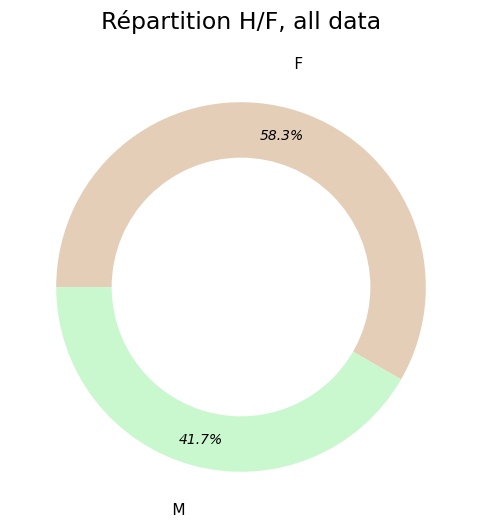

In [136]:
# Infos générales sur le dataset, exemple :
# répartition H/F (lecteurs/lectrices)

# nb de lecteurs/lectrices
print(raw_data['speaker'].nunique())
print(data['speaker'].nunique(), '\n')

# nb de livres différents
print(raw_data['book id'].nunique())
print(data['book id'].nunique())

doughnut(raw_data, 'gender', 'Répartition H/F, all data')


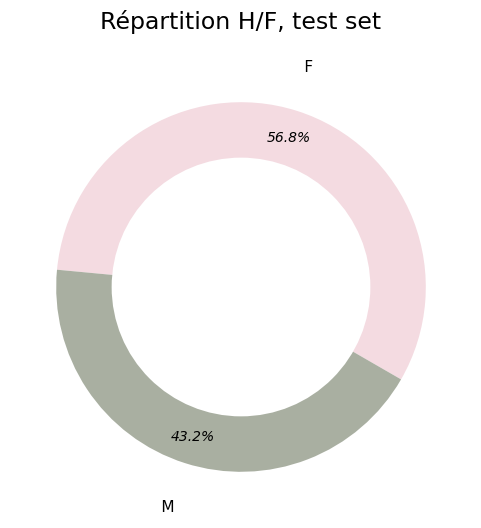

In [137]:
# sur notre testing set

doughnut(data, 'gender', 'Répartition H/F, test set')


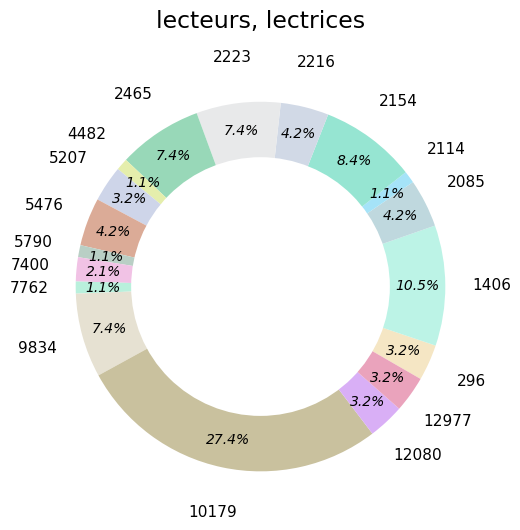

In [138]:
doughnut(data, 'speaker', 'lecteurs, lectrices', nb_colors=data['speaker'].nunique())


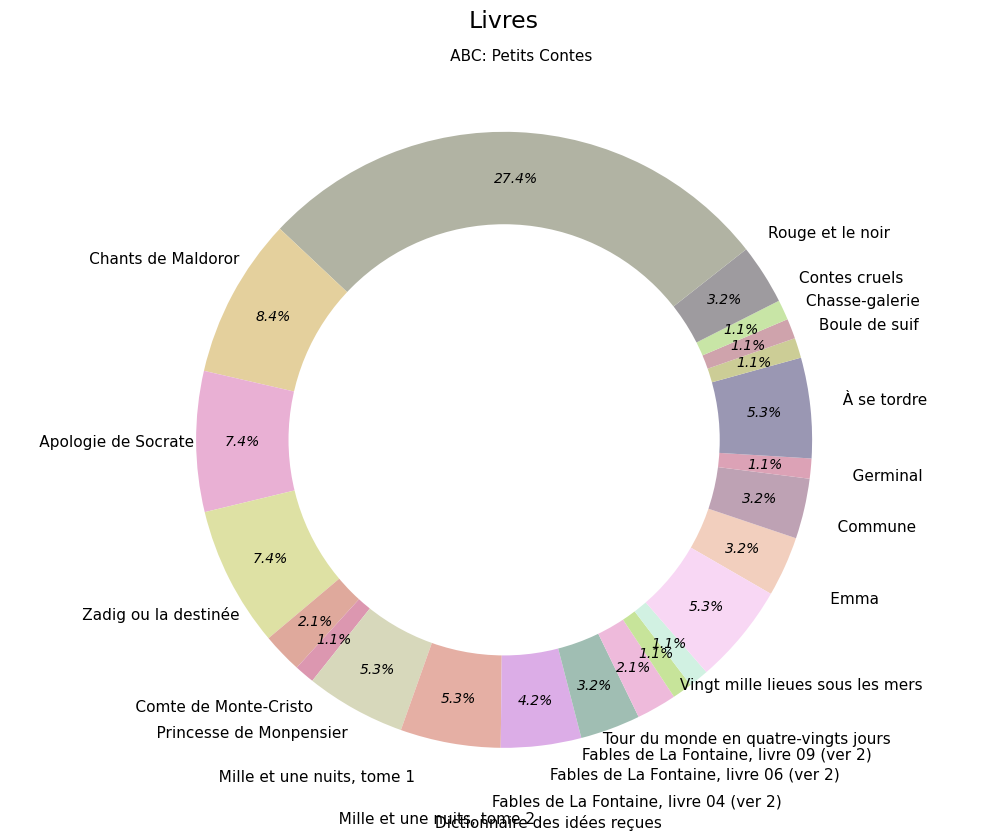

In [139]:
doughnut(data, 'title', 'Livres', width=10, height=10, nb_colors=data['title'].nunique())


### 1.8 EDA texte


In [140]:
# describe nb mots

# test_data['nb_chars'] = test_data[1].apply(len)
test_data['nb_words'] = test_data['true_transcript'].apply(lambda x: len(x.split()))

display(test_data[['nb_words']].describe())

# test_data.to_csv('./pickle/test_data.csv', sep='|', index=False)


,nb_words
count,2426.000000
mean,38.403545
std,10.827417
min,3.000000
25%,31.000000
50%,38.000000
75%,46.000000
max,73.000000


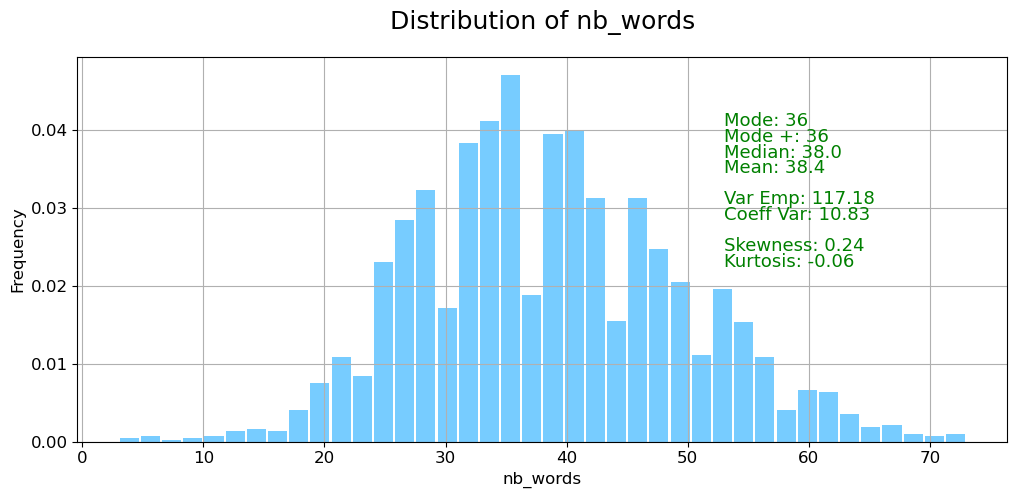

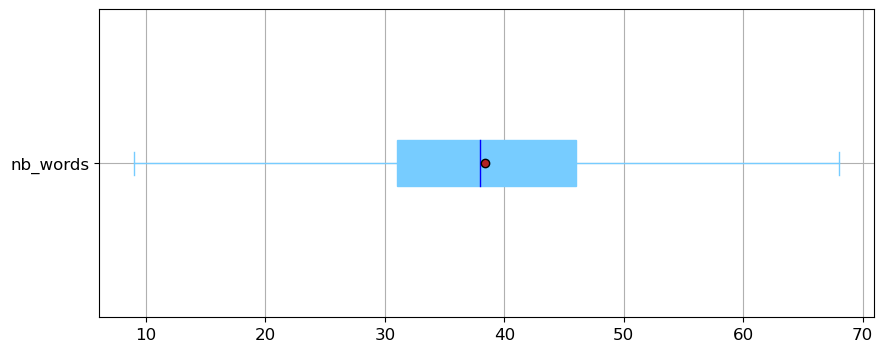

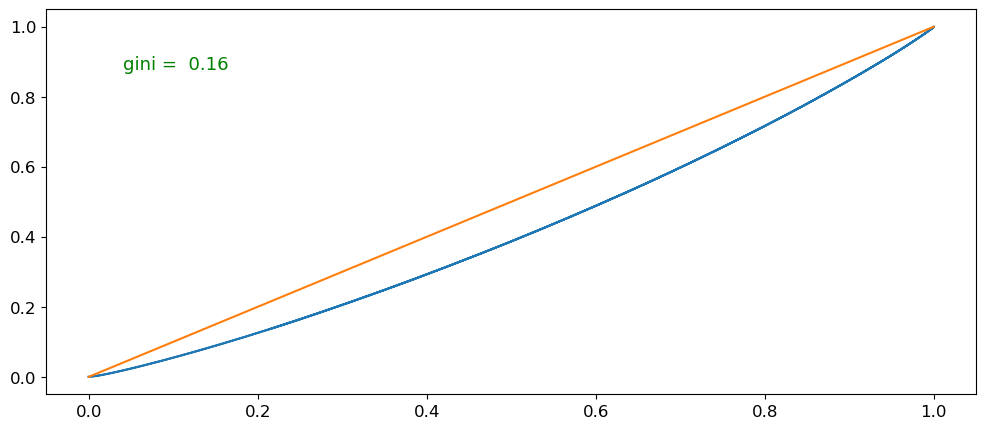

In [141]:
# Visualisation

graphs_analyse_uni(test_data, 'nb_words', bins=40, r=2)


In [142]:
# Observons qq transcripts

for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, ['true_transcript']].values[0][0], '\n')

# Pas de majuscules
# Pas de ponctuation, sauf apostrophes et tirets


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

1 

Texte d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage 

2 

Texte d'origine :
voilà ce qu'il y a de plus difficile à faire entendre à quelques-uns d'entre vous car si je dis que ce serait désobéir au dieu et que par cette raison il m'est impossible de me tenir en repos vous ne me croirez point et prendrez cette réponse pour une plaisanterie 

3 

Texte d'origine :
quand il fut grand on l'abattit on le dépouilla de son écorce et il devint selon son voeu grand mât sur une frégate mais il s'ennuyait à cause de la longueur et de la monotonie des traversées 

4 

Texte d'origine :
quel

### 1.9 EDA audio


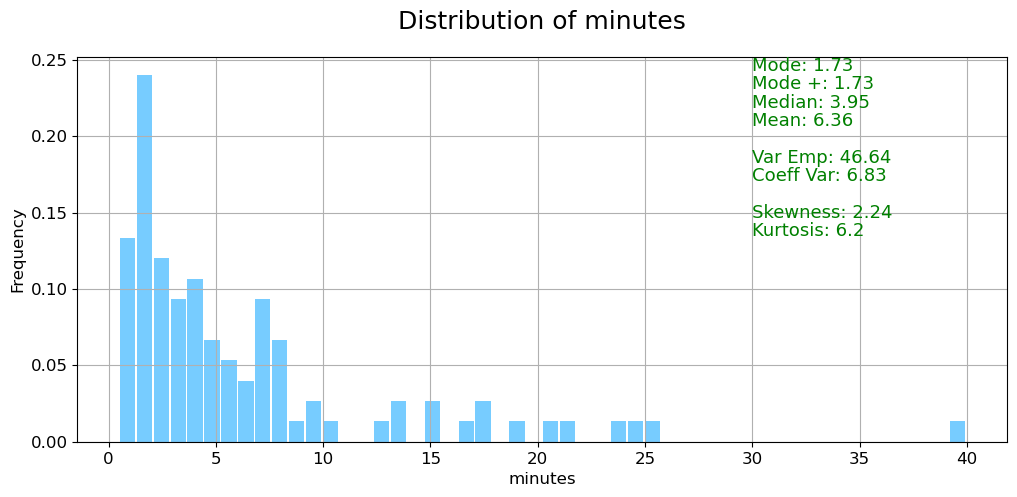

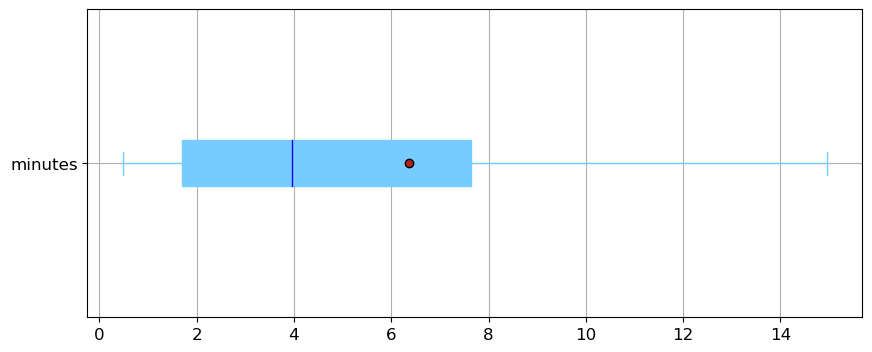

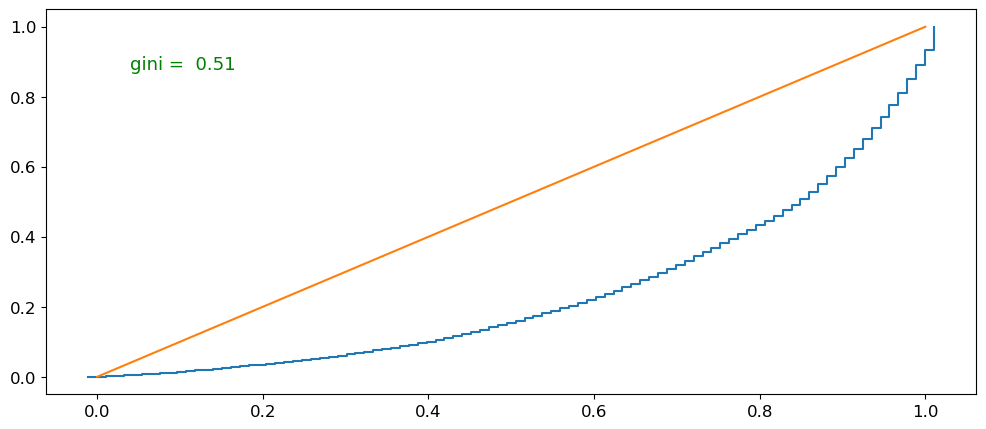

In [143]:
# Durée des enregistrements

graphs_analyse_uni(data, 'minutes', bins=50, r=2)

# Etonnament différent / nb mots.
# Ici : skewed à gauche
# nb mots : répartition gaussienne
# ??


In [144]:
# sample rate

def get_sample_rate(path):
    """ Retourne le sample rate d'origine """

    _, sample_rate = sf.read(path)

    return sample_rate

test_data['sample_rate'] = test_data['path'].apply(get_sample_rate)
test_data[['sample_rate']].describe()

# Tous encodés à 16 000 Hz
# (plutôt bas) (parfait pour whisper)


,sample_rate
count,2426.0
mean,16000.0
std,0.0
min,16000.0
25%,16000.0
50%,16000.0
75%,16000.0
max,16000.0


In [145]:
# graphs_analyse_uni(test_data, 'sample_rate', bins=70, r=2)
# Pas besoin du coup

exemple_path = './data/mls_french_opus/test/audio/2085/1565/2085_1565_000000.opus'

play_opus(exemple_path) # randomiser ?

# remarque : librosa modifie par défaut à 22 500 Hz (paramètre modifiable)

# origin
exemple_audio_sf, sample_rate_sf = sf.read(exemple_path)
print(sample_rate_sf) # (rappel)

# librosa
exemple_audio_librosa, sample_rate_librosa = librosa.load(exemple_path)
print(sample_rate_librosa)


16000
22050


## 2 Baseline, Transcription speech to text


In [31]:
# https://www.kaggle.com/code/stpeteishii/french-audio-wav2vec2-translation


Intro du notebook servant de baseline, présentation du modèle de transcription :

"facebook/wav2vec2-large-xlsr-53-french
The facebook/wav2vec2-large-xlsr-53-french model is a pre-trained speech recognition model that is specifically trained on French audio data. It is based on the Wav2Vec2 architecture, which is a transformer-based model that has been shown to be very effective for speech recognition tasks.

The facebook/wav2vec2-large-xlsr-53-french model is trained on a dataset of over 14,000 hours of French audio data. This data includes a variety of different speakers, recording conditions, and dialects. The model is also fine-tuned on a smaller dataset of manually transcribed French audio data.

Présentation du modèle utilisé pour la traduction :

facebook/nllb-200-distilled-600M
facebook/nllb-200-distilled-600M is a machine translation model from Facebook AI that can translate between 200 languages. It is a distilled version of the larger facebook/nllb-200-1.3B model, which was trained on a massive dataset of text and code. The distilled model is smaller and faster, but it still achieves state-of-the-art performance on translation tasks."


In [32]:
# Well, there is already a new state of the art.


### 2.1 Wav2Vec2


In [147]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")

# Get the state dictionary of the model
state_dict = model.state_dict()

# Save the state dictionary to a file using pickle
baseline_model_path = './data/baseline.pkl'
#with open(baseline_model_path, 'wb') as f:
    #pickle.dump(state_dict, f)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-french were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights 

In [34]:
def get_wav2vec_transcription(path):
    """ Retourne la transcription speech to text effectuée par wav2vec2, la baseline,
    depuis l'adresse du fichier audio
    """
    # Load the audio with the librosa library
    input_audio, _ = librosa.load(path, sr=16000)
    # data, sample_rate = librosa.load(file_path)
    # Tokenize the audio
    input_values = tokenizer(input_audio, return_tensors="pt", padding="longest").input_values
    # Feed it through Wav2Vec & choose the most probable tokens
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
    # Decode & add to our caption string
    transcription = tokenizer.batch_decode(predicted_ids)[0]

    return transcription


time_start = time.time()
test_data['baseline'] = test_data['path'].apply(get_wav2vec_transcription)
time_end = time.time()

time_predict_baseline = time_end - time_start
time_predict_baseline_moy = round(time_predict_baseline / test_data.shape[0], 2)

print(f'{time_predict_baseline_moy} s')
test_data.head()

# ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
# ?


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


5.48 s


,index,path,true_transcript,nb_words,sample_rate,baseline
0,1491,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et millière sortirent également le gou...,35,16000,blanqui et milliare sortirent également le gou...


In [35]:
# Observons qq résultats

for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, ['true_transcript']].values[0][0], '\n')

    print('Transcript wav2vec2 :')
    print(test_data.loc[test_data.index == index, ['baseline']].values[0][0], '\n')

# semble OK, seule ponctuation : tirets du 6 (hyphen -) et apostophe (')
# pour le true transcript comme pour la baseline
# + lower, srtip


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale 



## 3 Nouvelle méthode


In [36]:
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

# 461 M
# 1 G avec pickle ??


In [37]:
model_path = f'./data/whisper_{model_type}.pkl'

# with open(model_path, 'wb') as f:
    # pickle.dump(model, f)


In [38]:
#Loading
audio_test = whisper.load_audio(exemple_path)
audio_test


array([-2.3345947e-02, -2.0599365e-02, -2.1789551e-02, ...,
        9.1552734e-05, -2.2277832e-03,  1.1901855e-03], dtype=float32)

In [39]:
audio = whisper.pad_or_trim(audio_test)

#Number of samples in our trimmed/padded audio
n_samples =  audio.shape[-1]
n_samples


480000

Avant


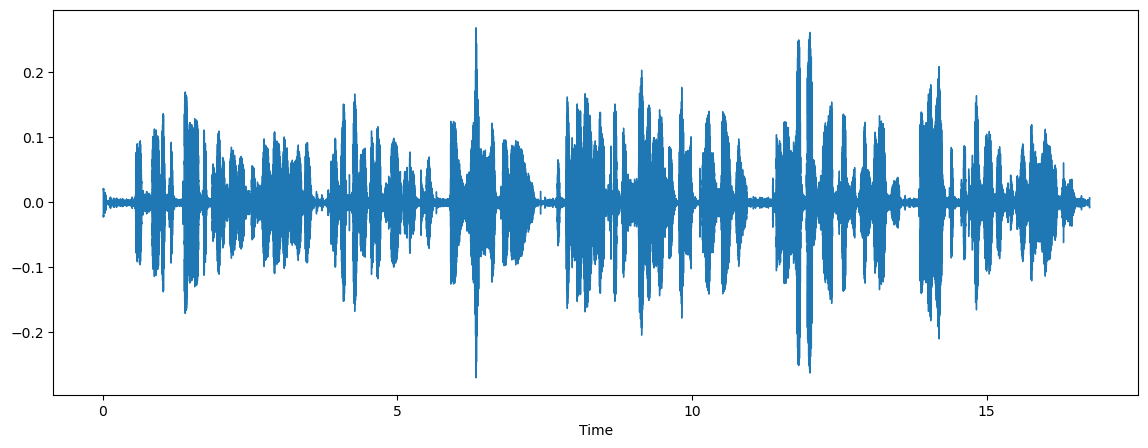

Après


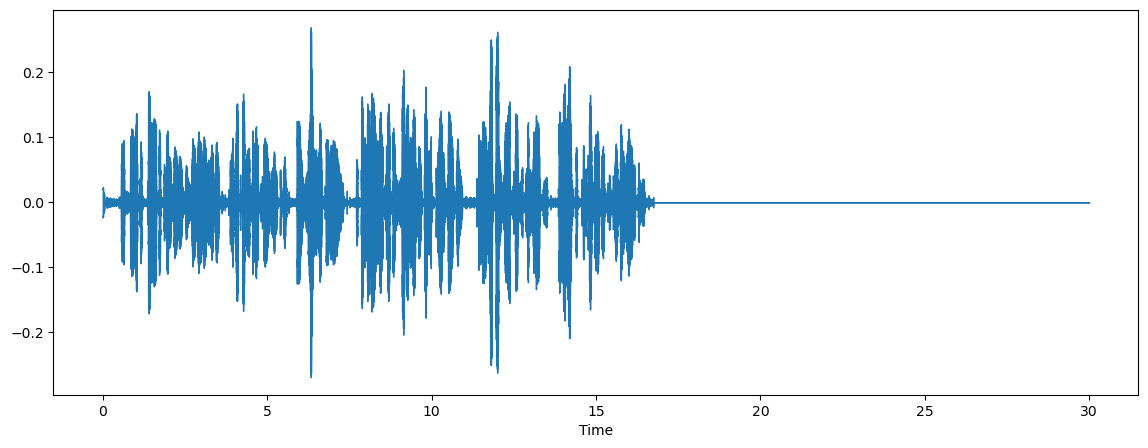

In [148]:
# original
print('Avant')
plt.figure(figsize=(14,5))
# plt.axis('off')
librosa.display.waveshow(exemple_audio_sf, sr=sample_rate_sf)

plt.show()

# après trimming
print('Après')
plt.figure(figsize=(14,5))
librosa.display.waveshow(audio,sr=sample_rate_sf)
plt.show()


In [39]:
mel = whisper.log_mel_spectrogram(audio).to(model.device)
print(mel.shape) # 80 features ok. 3000 ?

# (On reparlera de l'extraction de feature par mel encoding en conclusion)


torch.Size([80, 3000])


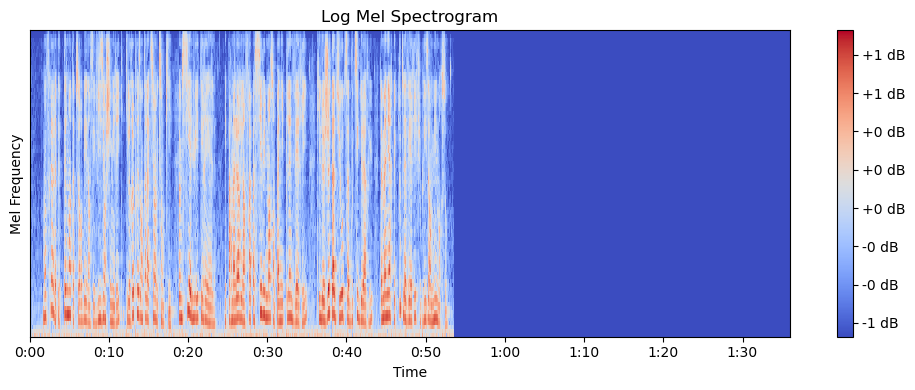

In [40]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel.numpy(), sr=sample_rate_sf, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

# bioutiful


In [41]:
if model_type != 'large':
    probs = model.detect_language(mel)
    print(len(list(probs[1])))
    probs[1]


99


In [42]:
if model_type != 'large':

    # Sort the dictionary based on predicted probabilities in descending order
    sorted_dict_probs = dict(sorted(probs[1].items(), key=lambda item: item[1], reverse=True))

    for langage, proba in list(sorted_dict_probs.items())[:1]:
        print(f'Langage détecté : {langage} ({proba}%)')

    transcription = model.transcribe(exemple_path, fp16 = False)['text']
    print(transcription)

# wow


Langage détecté : fr (0.9915708303451538%)


 Mon frère était tellement absorbé dans ces visions chimériques qui le représentent à l'action avec son pied, comme si elle lui était réel. Et par malheure, il en frappe assez vulnément son panique pleine verri, qui le jetade du haute sa boutique de la rue, de manière que toute la verri fut brise en 1000 morceaux.


### Prédictions sur testing set


In [43]:
def get_whisper_transcription(path):
    """ Retourne la transcription proposée par whisper, la nouvelle méthode """

    # syntaxe (encore) + courte !
    transcription = model.transcribe(path, fp16 = False)['text']

    return transcription


time_start = time.time()
test_data['new'] = test_data['path'].apply(get_whisper_transcription)
time_end = time.time()

time_predict_whisper = time_end - time_start
time_predict_whisper_moy = round(time_predict_whisper / test_data.shape[0], 2)

print(f'{time_predict_whisper_moy} s')
test_data.head()


# bcp + long, environ 6x
# (3 min pour whisper medium, contre 20s pour wav2vec2, sur 5 transcriptions

# Prend aussi + de ressources
# (presque 3 Go de + sur la RAM)

# Les performances sont-elles à la hauteur ?
# Déjà, on a la ponctuation !
# ... ce qui va par ailleurs compliquer (un tout petit peu) l'évaluation...


1.97 s


,index,path,true_transcript,nb_words,sample_rate,baseline,new
0,1491,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et millière sortirent également le gou...,35,16000,blanqui et milliare sortirent également le gou...,Blanchez et millière sortire-tégalement. Le g...
1,387,./data/mls_french_opus/test/audio/10179/11051/...,il n'est pas si vilain que ça dirent les cygne...,40,16000,il n'est pas ci vilain que ça dirent les cygne...,"Il n'est pas suivi l'un que ça, dire les sign..."
2,1192,./data/mls_french_opus/test/audio/2465/1943/24...,voilà ce qu'il y a de plus difficile à faire e...,50,16000,voilà ce qu'il y a de plus difficile à faire e...,Voilà ce qu'il y a de plus difficile à faire ...
3,410,./data/mls_french_opus/test/audio/10179/11051/...,quand il fut grand on l'abattit on le dépouill...,37,16000,quand il fut grand on l'abattit on le dépouill...,"Quand il fut grand, on l'abattie, on les dépu..."
4,482,./data/mls_french_opus/test/audio/12080/11650/...,quel admirable talent se dit julien quand il s...,38,16000,quel admirable talent se dit julien quand il s...,"Quel aide merable talan se dit Julien, quanti..."


In [44]:
# Un peu dommage d'avoir à faire ça

def remove_punctuation(string):
    """Sauf tirets et apostophes"""

    # remove_punctuation using regex + lower
    string = re.sub(r'[^\w\s\'\-]', '', string).lower().strip()

    return string


test_data['new_no_punct'] = test_data['new'].apply(remove_punctuation)

test_data.head()


,index,path,true_transcript,nb_words,sample_rate,baseline,new,new_no_punct
0,1491,./data/mls_french_opus/test/audio/7400/2928/74...,blanqui et millière sortirent également le gou...,35,16000,blanqui et milliare sortirent également le gou...,Blanchez et millière sortire-tégalement. Le g...,blanchez et millière sortire-tégalement le gou...
1,387,./data/mls_french_opus/test/audio/10179/11051/...,il n'est pas si vilain que ça dirent les cygne...,40,16000,il n'est pas ci vilain que ça dirent les cygne...,"Il n'est pas suivi l'un que ça, dire les sign...",il n'est pas suivi l'un que ça dire les signes...
2,1192,./data/mls_french_opus/test/audio/2465/1943/24...,voilà ce qu'il y a de plus difficile à faire e...,50,16000,voilà ce qu'il y a de plus difficile à faire e...,Voilà ce qu'il y a de plus difficile à faire ...,voilà ce qu'il y a de plus difficile à faire e...
3,410,./data/mls_french_opus/test/audio/10179/11051/...,quand il fut grand on l'abattit on le dépouill...,37,16000,quand il fut grand on l'abattit on le dépouill...,"Quand il fut grand, on l'abattie, on les dépu...",quand il fut grand on l'abattie on les députia...
4,482,./data/mls_french_opus/test/audio/12080/11650/...,quel admirable talent se dit julien quand il s...,38,16000,quel admirable talent se dit julien quand il s...,"Quel aide merable talan se dit Julien, quanti...",quel aide merable talan se dit julien quantif ...


In [45]:
# J'ai appris par la suite que Whisper possède sa propre méthode de normalisation
# (presque = à ce qu'on a fait, lowering + ponctuation removal)
# mais il enlève les apostrophes (et les tirets) :

%pip install whisper_normalizer
# / pip install git+https://github.com/kurianbenoy/whisper_normalizer.git
from whisper_normalizer.basic import BasicTextNormalizer

normalizer = BasicTextNormalizer()
normalizer("I'm a little teapot, short and stout. Tip me over and pour-me-out!")
# -> 'i m a little teapot short and stout tip me over and pour me out '


Note: you may need to restart the kernel to use updated packages.


'i m a little teapot short and stout tip me over and pour me out '

## 4 Comparaison


In [46]:
for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, ['true_transcript']].values[0][0], '\n')

    print('Transcript wav2vec2 :')
    print(test_data.loc[test_data.index == index, ['baseline']].values[0][0], '\n')

    print('Transcript whisper :')
    print(test_data.loc[test_data.index == index, ['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    print(test_data.loc[test_data.index == index, ['new_no_punct']].values[0][0], '\n')

# seems ok


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript whisper :
 Blanchez et millière sortire-tégalement. Le gouvernement n'a pas d'abord montré son mépris de la parole de l'année. Le soir même du 30e octobre avait lieu à la bourse une réunion des officiers de la garde national. 

Transcript whisper (no punct) :
blanchez et millière sortire-tégalement le gouvernement n'a pas d'abord montré son mépris de la parole de l'année le soir même du 30e octobre avait lieu à la bourse une réunion des officiers de la garde national 

1 

Texte d'origine :
il n'est pas si vilain 

### 4.1 Metrique


In [47]:
# https://www.kaggle.com/code/kevinvaishnav/speechtotext


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    #print(ref_words, hyp_words)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


In [48]:
# exemples

print(_levenshtein_distance('abc', 'abcd')) # 1 transformation nécessaire (ajouter character d)
print(_levenshtein_distance('abc', 'ABC'), '\n') # Sensible à la casse !

print(wer('Ils sont partis', 'ils sont parti')) # taux = 2 erreurs / 3 mots (env 0.67)
print(wer('Ils sont partis', 'i sont pati')) # Compte une erreur max par mot

# Le wer ressemble aux règles utilisées pour noter une dictée à l'école.
# Il ne fait pas la différence entre une "petite erreur", par exemple un accent,
# et un mot complet mal transcrit.

# Du coup, quand +ieurs orthographes sont acceptées, c'est le transcript de référence qui compte.
# Par exemple si 2 orthographes sont possibles, le modèle a 1 chance sur 2 de renvoyer la "bonne".

# Cete métrique n'est donc pas parfaitement juste et objective, comme le sont un r2, une rmse, l'accuracy, etc...
# Elle nous permet cependant d'évaluer et de comparer nos modèles, à condition de l'utiliser
# sur un testing set suffisamment important pour corriger les aléas statistiques.


1
3 

0.6666666666666666
0.6666666666666666


### Eval


In [49]:
liste_wer_wav2vec = []
liste_wer_whisper = []

for index in test_data.index:
    print(f'{index}', '\n')

    df = test_data.loc[test_data.index == index, :]

    print('Texte d\'origine :')
    txt_origin = df[['true_transcript']].values[0][0]
    print(txt_origin, '\n')

    print('Transcript wav2vec2 :')
    transcript_baseline = df[['baseline']].values[0][0]
    print(transcript_baseline)

    wer_baseline = wer(txt_origin, transcript_baseline)
    print(wer_baseline, '\n')
    liste_wer_wav2vec.append(wer_baseline)

    print('Transcript whisper :')
    print(df[['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    transcript_new_clean = df[['new_no_punct']].values[0][0]
    print(transcript_new_clean)

    wer_new = wer(txt_origin, transcript_new_clean)
    print(wer_new, '\n')
    liste_wer_whisper.append(wer_new)


# moyennes
mean_wer_baseline = np.mean(liste_wer_wav2vec)
mean_wer_new = np.mean(liste_wer_whisper)

# écarts-types
std_wer_baseline = np.std(liste_wer_wav2vec)
std_wer_new = np.std(liste_wer_whisper)

print(mean_wer_baseline)
print(mean_wer_new)

# Serré !
# whisper medium > wav2vec2 > whisper small
# (proche, différence environ 1%)

# whisper base bcp + rapide, mais fait 2x + d'erreurs

# tracker tps pred moy

# whisper large
# bcp + long (1 min par pred en moyenne)
# mais les résultats sont impressionnants !


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale
0.11428571428571428 

Transcript whisper :
 Blanchez et millière sortire-tégalement. Le gouvernement n'a pas d'abord montré son mépris de la parole de l'année. Le soir même du 30e octobre avait lieu à la bourse une réunion des officiers de la garde national. 

Transcript whisper (no punct) :
blanchez et millière sortire-tégalement le gouvernement n'a pas d'abord montré son mépris de la parole de l'année le soir même du 30e octobre avait lieu à la bourse une réunion des officiers de la garde national
0.2571428571428571 

1 

Te

### save results


In [50]:
# baseline

path_results_wav2vec = f'./pickle/results_baseline_{size_test}.pkl'

results_baseline = {
    'model': f'wav2vec2',
    'size test set': f'{size_test}',
    'WER moyen': f'{mean_wer_baseline:.3f}',
    'WER std': f'{std_wer_baseline:.3f}',
    'time predict moyen (s)': f'{time_predict_baseline_moy}'
}

with open(path_results_wav2vec, 'wb') as f:
        pickle.dump(results_baseline, f)

# new

path_results_whisper = f'./pickle/results_whisper_{model_type}_{size_test}.pkl'

results_whisper = {
    'model': f'whisper_{model_type}',
    'size test set': f'{size_test}',
    'WER moyen': f'{mean_wer_new:.3f}',
    'WER std': f'{std_wer_new:.3f}',
    'time predict moyen (s)': f'{time_predict_whisper_moy}'
}

with open(path_results_whisper, 'wb') as f:
        pickle.dump(results_whisper, f)


In [51]:
# display results


def check_results(path=f'./pickle'):
    """ Compare transcription models """

    data_path = glob(path+f'/*results*.pkl')
    list_files = [file for file in data_path]
    print(len(list_files))

    dfs = []

    for file in list_files:
         with open(file, 'rb') as f:
            params_dict = pickle.load(f)
            df = pd.DataFrame.from_dict(params_dict, orient='index').T
            dfs.append(df)

    if dfs:
        result_df = pd.concat(dfs, ignore_index=True)
        return result_df
    else:
        print("No pickled dictionaries found.")
        return None


result_df = check_results()

# Sort the DataFrame by wer in descending order (lower is better)
result_df.sort_values(by='WER moyen', ascending=True, inplace=True)

display(result_df.head(10))  # Display the concatenated DataFrame


8


,model,size test set,WER moyen,WER std,time predict moyen (s)
6,whisper_large,300,0.070,0.098,74.27
4,wav2vec2,20,0.103,0.082,4.32
1,whisper_medium,300,0.117,0.208,39.64
2,wav2vec2,300,0.139,0.115,4.05
0,whisper_small,300,0.156,0.140,12.41
3,whisper_base,300,0.263,0.165,4.62
5,whisper_tiny,20,0.328,0.148,1.97
7,whisper_tiny,300,0.383,0.181,2.8


## 5 Traduction (du français vers l'anglais)


### 5.1 baseline


In [52]:
#

model = AutoModelForSeq2SeqLM.from_pretrained( 'facebook/nllb-200-distilled-600M')
model.eval()
model.to(model.device)
tokenizer = AutoTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer.save_pretrained('./data/tokenizer/')


def translate_by_nllb(text, tokenizer, model, device):
    """ Translate a text from french to english, using nllb"""

    inputs = tokenizer(text, return_tensors="pt")
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    translated_tokens = model.generate(
        **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"], max_length=64
    )
    return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]


trads_baseline = []
for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print("Traduction baseline :")
    traduction = translate_by_nllb(test_data['baseline'][index], tokenizer, model, model.device)
    trads_baseline.append(traduction)
    print(traduction, '\n')

# Pas mal du tout
# Des erreurs, loin d'être parfait, mais on comprend le sens général.

# avec : 0 on comprend rien / 1 mmm ok / 2 bien / 3 wow
# 0: 2
# 1: 2 3
# 2: 3
# 3: 2
# 4: 1-2
# ... vraiment correct, sur des textes difficiles.


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
Traduction baseline :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
Traduction baseline :
It is not a villain that they say the cygnes and a mseu sign with a magnificent plastron blanc et de beaux pieds Vernis declares that he remains among us and in three months I will give him my daughter in marriage 

2 Texte fr d'origine :
voilà ce qu'il y a de plus difficile à faire e

### 5.2 whispers


In [53]:
# tiny
model_type = 'tiny'
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print('traduction baseline (rappel) :')
    print(trads_baseline[index])
    print(f"Traduction whisper {model_type}:")
    traduction = model.transcribe(test_data['path'][index], language = 'en', fp16 = False)['text']
    print(traduction, '\n')

# aïe aïe aïe !
# incompréhensible


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
traduction baseline (rappel) :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard
Traduction whisper tiny:
 It'sιBlan stretcher,<|my|>朝sterelle… They believe one should not really continue for spicy food. Even the tendercekts come back in the mouth would finally bethe core of the nationals's company. 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
traduction baseline (rappel) :
It is not a villain that they say the cygnes an

In [54]:
# base
model_type = 'base'
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print('traduction baseline (rappel) :')
    print(trads_baseline[index])
    print(f"Traduction whisper {model_type}:")
    traduction = model.transcribe(test_data['path'][index], language = 'en', fp16 = False)['text']
    print(traduction, '\n')

# mieux,
# mais pas mieux que la baseline
# + rapide que tiny ??


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
traduction baseline (rappel) :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard
Traduction whisper base:
 Jai have? request? christ d request? 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
traduction baseline (rappel) :
It is not a villain that they say the cygnes and a mseu sign with a magnificent plastron blanc et de beaux pieds Vernis declares that he remains among us and in three months I will give him my daughter in

In [55]:
# small
model_type = 'small'
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print('traduction baseline (rappel) :')
    print(trads_baseline[index])
    print(f"Traduction whisper {model_type}:")
    traduction = model.transcribe(test_data['path'][index], language = 'en', fp16 = False)['text']
    print(traduction, '\n')

# encore mieux,
# mieux que la baseline ? pas sûr


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
traduction baseline (rappel) :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard
Traduction whisper small:
 Blanqui and Milier also came out. The government did not show its contempt for the word of God first. Even on October 31, a meeting of the National Guard officers took place at the stock market 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
traduction baseline (rappel) :
It is not a villain that they say the cygnes a

In [56]:
# medium
model_type = 'medium'
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print('traduction baseline (rappel) :')
    print(trads_baseline[index])
    print(f"Traduction whisper {model_type}:")
    traduction = model.transcribe(test_data['path'][index], language = 'en', fp16 = False)['text']
    print(traduction, '\n')

# beaucoup mieux,
# presque parfait. Restent qq erreurs qui peuvent gêner la compréhension
# + lent
# 1 non traduit, le 18


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
traduction baseline (rappel) :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard
Traduction whisper medium:
 Blanqui and Millière also went out. The government did not dare to show its contempt for the speech. On the evening of October 31, a meeting of the National Guard officers took place at the stock exchange. 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
traduction baseline (rappel) :
It is not a villain that they say

In [57]:
# large
model_type = 'large'
model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded")

for index in test_data.index[:max_exemples]:
    print(f"{index} Texte fr d'origine :")
    print(test_data['true_transcript'][index])
    print('traduction baseline (rappel) :')
    print(trads_baseline[index])
    print(f"Traduction whisper {model_type}:")
    traduction = model.transcribe(test_data['path'][index], language = 'en', fp16 = False)['text']
    print(traduction, '\n')

# excellent (tjs pas parfait)
# mais très lent, environ
# 1, 6, 9, pas traduits ???
# La traduction de la baseline parait meilleure...
# whisper medium semblait meilleur en fait ??


0 Texte fr d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale
traduction baseline (rappel) :
Blanqui et milliare sortirent also the government not daring to show its contempt of the parole de naissance on the evening of October had held at the bourse a meeting of officers of the National Guard
Traduction whisper large:
 blanqui and millière also left the government did not dare to show his contempt for the word given on the very evening of october thirty-first a meeting of the officers of the national guard 

1 Texte fr d'origine :
il n'est pas si vilain que ça dirent les cygnes et un monsieur cygne avec un magnifique plastron blanc et de beaux pieds vernis déclara qu'il reste parmi nous et dans trois mois je lui donne ma fille en mariage
traduction baseline (rappel) :
It is not a villain that they say the cygnes and 

In [58]:
# notre exemple test du début

translation = model.transcribe(exemple_path, language = 'en', fp16 = False)['text']
translation

# marrant
# pas parfait mais excellent. a corrigé "verris" !


" mon frere était tellement absorbé dans ses visions chimériques qu'il représenta l'action avec son pied comme si elle eût été réelle et par malheur il en frappa si rudement son panier plein de verreries qu'il le jeta du haut de sa boutique de la rue de manière que toute la verrerie fut brisée en mille morceaux"

In [59]:
translation = model.transcribe(exemple_path, language = 'ja', fp16 = False)['text']
translation

# ?? Qqn sait si c bon ?
# Watashi no, ça commence bien. Après les kanjis...


'私の兄弟はこの化学的な視線に沢山の気持ちを吸収していたので、彼は彼の足で行動を表した。彼は彼の足で行動を表した。'

## Synthèse


### Baseline : Concept, architecture, ...


In [60]:
# wav2vec 2, architecture générale : transformer encoder decoder)
# source : https://jonathanbgn.com/2021/09/30/illustrated-wav2vec-2.html

# le modèle se compose de trois modules principaux :
# 1 - Feature encoder :  a 7-layer convolutional neural network (single-dimensional)
# with 512 channels at each layer
# 2 - Discrétisation : le modèle a appris à découper la parole enregistrée en segments.
# 3 - Le réseau contextuel (decoder du transformer) takes as input the latent feature vectors
# and processes it through 12 to 24 Transformer blocks (base version 12, large 24)

# Les modèles comme word2vec2, que nous avons pris comme baseline,
# ou seq2seq de google, qui est assez similaire dans son architecture
# (multiple LSTM RNNs, attention-based or not depending on the versions),
# sont vraiment performants et présentent de nombreux avantages.


### ... Pros, ...


In [61]:
# En résumé : ils permettent de tokenizer puis transcrire un "speech", une parole enregistrée,
# pour un langage donné, en utilisant un espace d'embedding contextualisé.
# Ils sont donc une application directe aux inputs audios de méthodes qui ont fait leurs preuves
# dans le domaine du NLP (traitement du langage naturel, traditionnellement du texte écrit).

# can be used for a variety of speech downstream tasks: automatic speech recognition,
# emotion detection, speaker recognition, language detection…

# Combinés à un algorithme de traduction automatique, (ici nllb)
# ils constituent le premier pipeline de traduction automatisée d'une langue parlée vers une autre.
# L'exemple le plus connu de diffusion gratuite de cet outil est sans doute google translate.
# Pour ce projet nous avons plutôt utilisé wav2vec2 de facebook, car il possédait encore
# très récemment (avant l'arrivée des LLM) le WER le plus bas (meilleur en transcription).

# Encore une fois, d'un point de vue technique ces modèles se ressemblent :
# word embedding pour wav2vec contre sentence embedding pour seq2seq.
# Ils présententent les mêmes avantages : rapides et efficaces,
# donnant un résultat souvent satisfaisant en quelques secondes.


### ... and cons


In [62]:
# Ils possèdent aussi les mêmes points faibles :

# Entraînés d'abord de manière non-supervisée sur un dataset très large,
# pour créer l'espace d'embedding, (1 000 000 d'heures de data audio pour wav2vec 2.0)
# ces modèles doivent ensuite être fine-tunés de manière supervisée sur un dataset
# (beaucoup plus réduit, environ 1 000 h) contenant la feature (audio) et les targets (transcripts),
# pour créer le "dictionnaire" (la matrice d'embedding), permettant de faire le lien
# entre les vecteurs de l'espace d'embedding et les mots correspondants.

# Cette opération de fine-tuning peut diminuer la capacité de généralisation des modèles.
# source : https://medium.com/axinc-ai/whisper-speech-recognition-model-capable-of-recognizing-99-languages-5b5cf0197c16

# Deuxième point à noter :
# La langue doit être précisée, car un modèle de transcription de ce type ne fonctionne
# que pour une langue, celle sur laquelle il a été entraîné.
# Cela implique aussi de charger un modèle de transcription spécifique
# (+ un modèle de traduction) pour chaque langue que l'on souhaite prendre en charge.
# Pour la traduction c'est pire, car il faudrait en réalité un modèle pour chaque
# combinaison possible langue d'entrée / langue de sortie !
# Cela semble faisable pour quelques langues, mais pourrait vite poser des probèmes
# si l'on souhaiter gérer une centaine de langues, comme le fait whisper.

# Cela explique peut-être en partie le fait que très peu de langues sont disponibles.
# Google traduction en propose officiellement 32 pour l'appli mobile android.
# D'ailleurs dans le cas de google translate, on peut aussi noter que cette option (speech to text)
# n'est compatible qu'avec certains navigateurs uniquement...
# Sur ma distribution de linux mint, en fait elle ne fonctionne :

# ni avec mozilla
# ni avec opera
# ni avec midori

# mieux :
# elle ne fonctionne pas non plus avec chromium !
# Elle fait crasher ma version dev de edge (quand je clique sur le micro) !...
# Pas parfaitement au point disons.

# Sur mobile android, l'appli semble bien fonctionner.
# Pas de version accessible hors-connexion


### New method


In [63]:
# whisper
# (same source, https://medium.com/axinc-ai/whisper-speech-recognition-model-capable-of-recognizing-99-languages-5b5cf0197c16)

# Architecture assez semblable à première vue,
# même famille de modèles : encoder-decoder transformer

# The encoder obtains a latent representation from mel encoded speech (80 features),
# and the decoder outputs text from the latent representation.
# L'extraction de features et la discrétisation (toutes les 30 secondes)
# semblent même + "rudimentaires", cependant cela offre au modèles de type whisper
# un avantage (considérable) :

# l'accès à un dataset bcp + important pour son entraînement

# Le bloc encoder de whisper a qt à lui été entraîné par apprentissage faiblement supervisé,
# en utilisant un gd nb de fichiers audio et de textes disponibles sur internet
# (680 000 heures speech and text, en 99 langues).
# Etant entraîné sur des datasets plus larges, il est plus précis.

# Deuxième avantage (écrasant) : 57 (98) langues,
# détectées automatiquement !

# Des performances encore meilleures que wav2vec 2 pour l'anglais et le francais (whisper medium),
# 2 x meilleurs pour whisper large
# + traduction dans 98 x 97 langues possibles...
# avec 1 seul modèle !

# Seul inconvénient : medium et large sont bcp plus lents


### Pistes d'amélioration : feature extraction,


In [64]:
# Difficile d'imaginer quelles inovations, ou quelles applications nouvelles ou
# améliorations de technologies existantes vont pouvoir révolutionner le domaine, demain ou dans un an.
# Voici malgré tout quelques idées de pistes à explorer, l'avenir dira
# si elles se révèlent utiles.

# L'extraction de feature par mel-encoding

# J'avoue je suis un peu étonné que le traitement des données audio par whisper repose sur
# un mel frequency encoding au préalable, qui lui sert de preprocessing function.
# Je soupçonne que cela lui permet d'utiliser un dataset plus grand,
# et que cela n'a pas bcp d'importance ds ts les cas, le mel spectrogramm étant une méthode
# très efficace, et un standard très largement utilisé dans l'industrie.

# On peut cependant rappeler 2 choses :

# 1) le mel encoding, un peu comme la méthode sift dans le domaine des images, est un processus
# d'extraction de features audio élaboré de manière en partie empirique et en partie arbitraire.
# Quelle que soit la qualité des features obtenues, il y a fort à parier que,
# (exactement comme pour les modèles de classification d'image / vision par exemple)
# pour les prochaines générations, toute l'extraction de feature sera faite par le modèle lui-même,
# avec des premières couches / modules de data augmentation + extraction intégrée.
# Cette méthode, déjà largement implémentée dans le domaine de la compréhension d'images,
# me semble très prometteuse ici aussi, d'autant plus que :

# 2) L'application idéale du mel encoding, son objectif premier, n'est pas exactement
# d'opérer une extraction de features optimale pour un modèle de machine learning.
# Pas du tout en fait, cette technique ayant été inventée à la fin des années 1930.
# Il s'agit plutôt de traiter un signal sonore destiné à être entendu par une oreille humaine.
# Cela en fait un très bon "filtre" pour l'industrie musicale par exemple, puisqu'il est conçu :
# d'une part pour éliminer (atténuer) tous les sons inaudibles pour l'oreille humaine
# (trop grave, trop aigu, trop peu de volume), ce qui en fait un excellent outil de compression,
# tout en conservant d'autre part les sons que nous entendons.

# principes du mel encoding
# On commence par appliquer une transformée rapide de Fourier sur le spectrogramme original
# (pour cette partie je parie que le modèle fera qqch de similaire !
# cela semble en effet tout à fait naturel pour "lire" un son. En fait, je parie même
# qu'il ne devrait pas aller bcp + loin, les étapes suivantes me semblent
# pertinentes pour la compression mais il faudrait tester leur intérêt pour l'extraction)
# exemple :
# On utilise ensuite une échelle logarithmique pour isoler les sons situés
# hors de notre échelle de perception. Il est possible que cette étape soit inutile pour les modèles.
# Je doute que cela puisse impacter les prédictions des modèles de manière significative,
# cependant c'est un exemple d'optimisation possible.


### translitération


In [65]:
# La translitération

# Aucun procédé de translitération n'est implémenté à l'heure actuelle :
# La langue est détectée une fois, pour chaque transcription ou traduction.
# Le modèle est donc "perdu" si on change de langue pendant l'enregistrement.
# Il essaie alors de transcrire + ou - phonétiquement

# Voir l'appli pour tester :
# https://rosetta-stones.streamlit.app/

# Les datasets contiennent vraisemblablement (en proportion) très peu de data contenant des
# langues mélangées. Il est cependant probable que cette difficulté sera surmontée,
# par une innovation ou par l'amélioration de techniques existantes.

# Peut-être en utilisant des couches de data augmentation,

# ou simplement par des segments + courts (- de 30 secondes)
# et donc une détection + fréquente
# Modèles existants : cela semble envisageable pour whisper tiny ou base,
# qui sont très rapides (ce sont de "petits" modèles, avec respectivement :
# 4 couches et 39 M de paramètres pour tiny,
# 6 couches et 74 M de paramètres pour whisper base),
# mais leurs performances les limitent à des cas "faciles" uniquement.

# source : https://medium.com/axinc-ai/whisper-speech-recognition-model-capable-of-recognizing-99-languages-5b5cf0197c16

# Pour les modèles + performants, whisper medium et large,
# l'implémentation d'un système de ce type rendrait les prédictions, qui sont déjà longues,
# encore (beaucoup) plus longues. Pour référence :
# 24 couches et 769 M de paramètres pour whisper medium,
# 32 couches et 1550 M de paramètres pour whisper large

# Aussi, l'apprentissage faiblement supervisé permettant d'utiliser un dataset plus large
# (incluant probablement des fichiers de sous-titres) requiert des segments
# suffisament longs.


### Conclusion nouvelle méthode


In [66]:
# Ces modèles, large et medium, sont plus performants que notre baseline,
# qui affichait pourtant des résultats déjà excellents :
# ici un taux de mots identiques au true transcript supérieur à 86% (WER = 0.139)
# (sur des textes difficiles !)

# Ils permettent aussi (accessoirement !) la traduction depuis et à destination de 98 langues,
# avec une facilité d'implémentation étonnante :
# il n'y a même pas une ligne de code à ajouter,
# il suffit simplement de préciser le paramètre language à la méthode .transcribe() !

# Cela se fait au prix de prédictions plus longues à générer.
# Il y a en pratique un choix à faire, un compromis entre
# les performances souhaitées et le temps nécessaire pour les obtenir.
# C'est sans doute pour cette raison que whisper est dispobible en plusieurs versions


### Choix final


In [67]:
# En ce qui concerne notre restaurant, après avoir testé différents modèles,
# la cliente a préféré utiliser whisper medium,
# malgré sa "lenteur" relative.

# explication : Les clients ne parlant ni français ni anglais restent relativement rares,
# c'est pourquoi la priorité est mise sur la fiabilité de l'outil de traduction,
# afin d'être sûrs (autant que possible) de pouvoir se comprendre,
# dans des cas où ce serait autrement beaucoup plus difficile, voir impossible.
# Medium apparait donc comme le meilleur choix possible, compte-tenu du comportement parfois
# imprévisible de whisper large.

# Commentaire de la cliente : "Le délai serait + problématique pour un usage + fréquent.
# C'est incroyable de pouvoir traduire autant de langues, même le portuguais !"
# La gérante compte aussi utiliser l'appli pour voyager...
# dès qu'elle en aura le temps :)

# What a day to be alive !
